# Time Series Aanalysis

En este Notebook haremos uso de la libreria prophet de Facebook para predecir el precio del bitcoin en base al sentimiento en twitter en ese instante.

## Imports

In [1]:
import pandas as pd

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objs as go

from JABA.service.scrapper import DFPicker

## Prophet

### Pick the data

En primer lugar establecemos las fechas de inicio y fin de los datos, que por una parte se usaran para entrenar el modelo, y por otra, para establecer las fechas de las que se quiere realizar la predeccion.
Para todo esto es **necesario tener en la carpeta de data los valores de bitcoin y el sentimiento de twitter**.
Haremos uso de la funcion **get_complete_df(dateFrom, dateTo)** de **DFPicker** para recopilar los datos de las fechas de las que queremos realizar la observacion:

In [2]:
date_init = "2017-01-01"
date_limit = "2021-06-10"
date_init_predict = "2021-06-11"
date_limit_predict = "2021-06-17"
difference = 6

Recojemos los datos referentes a las fechas establecidas anteriormente.

In [3]:
# Data for fitting the model
fit_df = DFPicker.get_complete_df(date_init, date_limit)
data = { 'ds': fit_df.index.values,
         'y': fit_df.Close,
         'sentiment_v': fit_df.sentiment_v,
         'sentiment_v2': fit_df.sentiment_v2
       }
prophet_fit_df = pd.DataFrame(data, columns=['ds', 'y', 'sentiment_v', 'sentiment_v2'])
prophet_fit_df.reset_index(drop=True, inplace=True)

Current Date 2017-01-01
Current Date 2018-01-01
Current Date 2019-01-01
Current Date 2020-01-01
Current Date 2021-01-01
Current Date 2017-01-01
Current Date 2018-01-01
Current Date 2019-01-01
Current Date 2020-01-01
Current Date 2021-01-01
Extraction Completed!


In [4]:
# Data for the prediction (sentiment and dates)
future_data = DFPicker.get_complete_df(date_init_predict, date_limit_predict)
future_data['date'] = future_data.index.values
future_data['date'] = future_data['date'].dt.date
grouped_data = future_data.groupby(['date']).agg({'sentiment_v' : 'mean' , 'sentiment_v2' : 'mean', 'Datetime':'count'})

future_df = pd.concat([fit_df, grouped_data], ignore_index=False)
future_df['ds'] = future_df.index.values
future_df.Close.rename('y')
print(future_df)

#future_df = model.make_future_dataframe(periods=5)
#print(future_df.shape)
#future_df['sentiment_v'] = future.sentiment_v.values
#future_df['sentiment_v2'] = future.sentiment_v2.values

Extraction Completed!
                     sentiment_v  Datetime  sentiment_v2       Close  \
2017-01-01 00:00:00    45.280772       125     40.843113  933.682667   
2017-01-01 00:30:00    27.436598        79     25.955371  966.378667   
2017-01-01 01:00:00    28.693411        85     26.123574  964.624000   
2017-01-01 01:30:00    18.457868        68     17.010161  963.622000   
2017-01-01 02:00:00    25.855075        88     22.976924  964.385667   
...                          ...       ...           ...         ...   
2021-06-12            622.553142        48    545.567656         NaN   
2021-06-13            837.207509        48    733.991905         NaN   
2021-06-14            952.728691        48    865.568814         NaN   
2021-06-15            818.271594        48    733.468003         NaN   
2021-06-16            683.730928        32    613.186233         NaN   

                                     ds  
2017-01-01 00:00:00 2017-01-01 00:00:00  
2017-01-01 00:30:00 2017-01-0

### Model Evaluation

Definimos una funcion para comprobar si la prediccion del modelo es correcta

In [5]:
def model_score_lower_upper(forecast, real_data):
    score = 0

    real_data = real_data.groupby(['date']).agg({'Close' : 'mean'})
    print(forecast)
    for prediction in forecast.values:
        i=1
        print(prediction)
        print("Prediction lower =", prediction[2])
        print("Real Prize =", real_data.iloc[i].Close)
        print("Prediction upper =", prediction[3])
        if(prediction[2] < real_data.iloc[i].Close):
            score += 0.5
        if(prediction[3] > real_data.iloc[i].Close):
            score += 0.5
        i += 1
    print(i)
    score = score / forecast.shape[0]
    return score
    

In [6]:
model = Prophet()
model.add_regressor('sentiment_v')
model.add_regressor('sentiment_v2')
model.fit(prophet_fit_df)

forecast = model.predict(future_df)

In [ ]:
print(model_score_lower_upper(forecast, future_data))
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(120))


### Cross validation

In [11]:
df_cv = cross_validation(model, initial='900 days', period='90 days', horizon = '365 days', parallel="threads")
df_cv.head(100)


INFO:prophet:Making 4 forecasts with cutoffs between 2019-09-13 23:30:00 and 2020-06-09 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x0000029475DDC8B0>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-09-14 00:00:00,9751.585590,8973.177551,10467.901060,10329.108333,2019-09-13 23:30:00
1,2019-09-14 00:30:00,9711.060130,9002.573010,10494.968189,10312.842000,2019-09-13 23:30:00
2,2019-09-14 01:00:00,9771.073984,9026.722037,10572.672793,10304.727667,2019-09-13 23:30:00
3,2019-09-14 01:30:00,9646.882246,8918.163667,10351.893204,10306.758000,2019-09-13 23:30:00
4,2019-09-14 02:00:00,9713.651157,8926.359359,10429.834808,10300.893000,2019-09-13 23:30:00
...,...,...,...,...,...,...
95,2019-09-15 23:30:00,9642.468278,8916.116398,10360.116092,10302.963667,2019-09-13 23:30:00
96,2019-09-16 00:00:00,9792.842432,9101.904603,10538.613050,10319.867000,2019-09-13 23:30:00
97,2019-09-16 00:30:00,9642.000745,8890.859646,10364.868357,10323.204333,2019-09-13 23:30:00
98,2019-09-16 01:00:00,9740.226980,9006.306301,10506.627740,10341.556667,2019-09-13 23:30:00


In [12]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
15774,364 days 22:00:00,7.092199e+08,26631.183137,22754.569346,0.808602,0.783716,0.923491,1.0
15775,364 days 22:30:00,7.092544e+08,26631.831361,22755.065081,0.808641,0.783716,0.923505,1.0
15776,364 days 23:00:00,7.092978e+08,26632.645738,22755.660438,0.808682,0.783739,0.923523,1.0
15777,364 days 23:30:00,7.093392e+08,26633.421724,22756.313846,0.808724,0.783742,0.923545,1.0
15778,365 days 00:00:00,7.093841e+08,26634.265416,22756.944813,0.808765,0.783742,0.923563,1.0


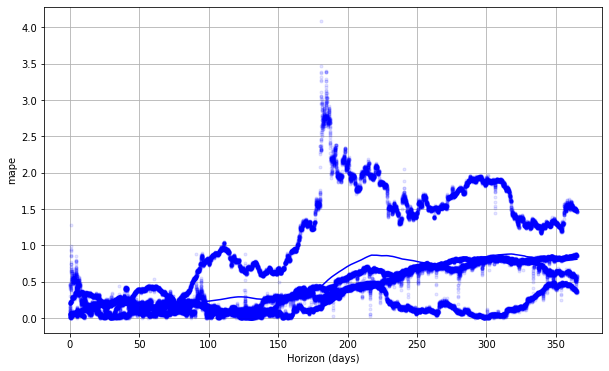

In [13]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


### Plotting the results

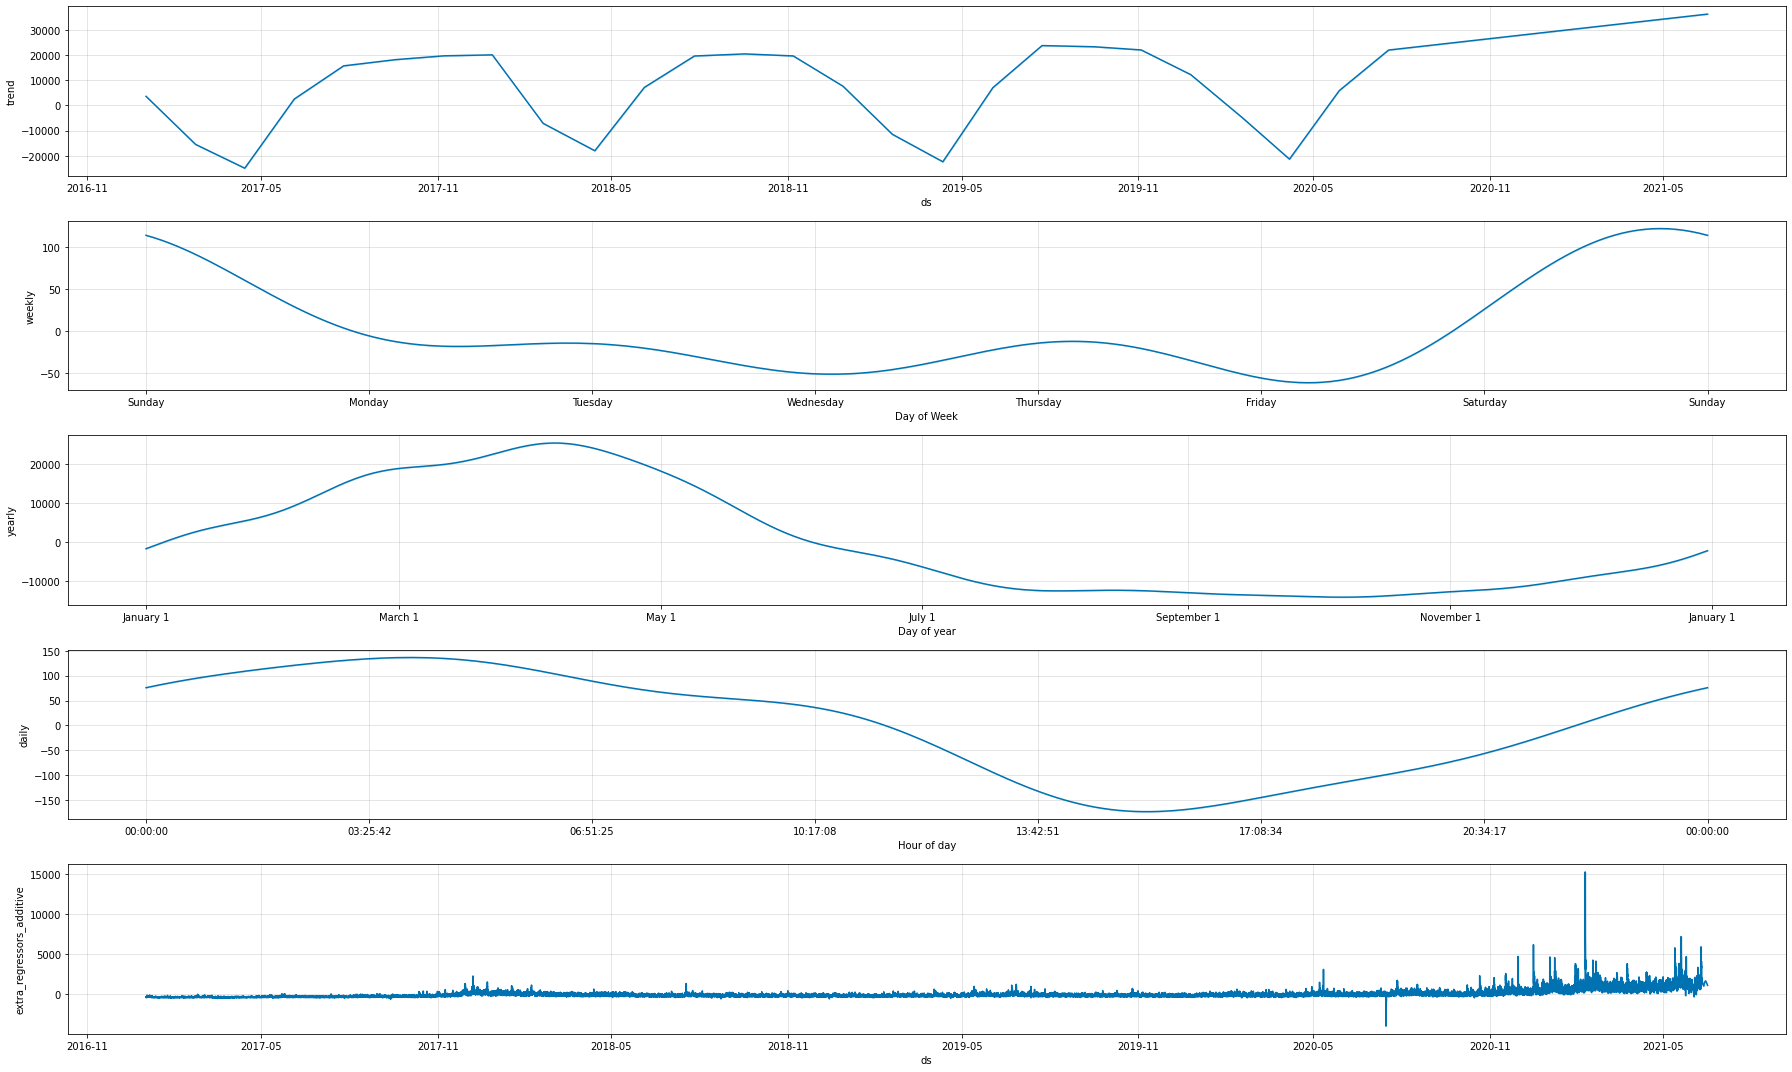

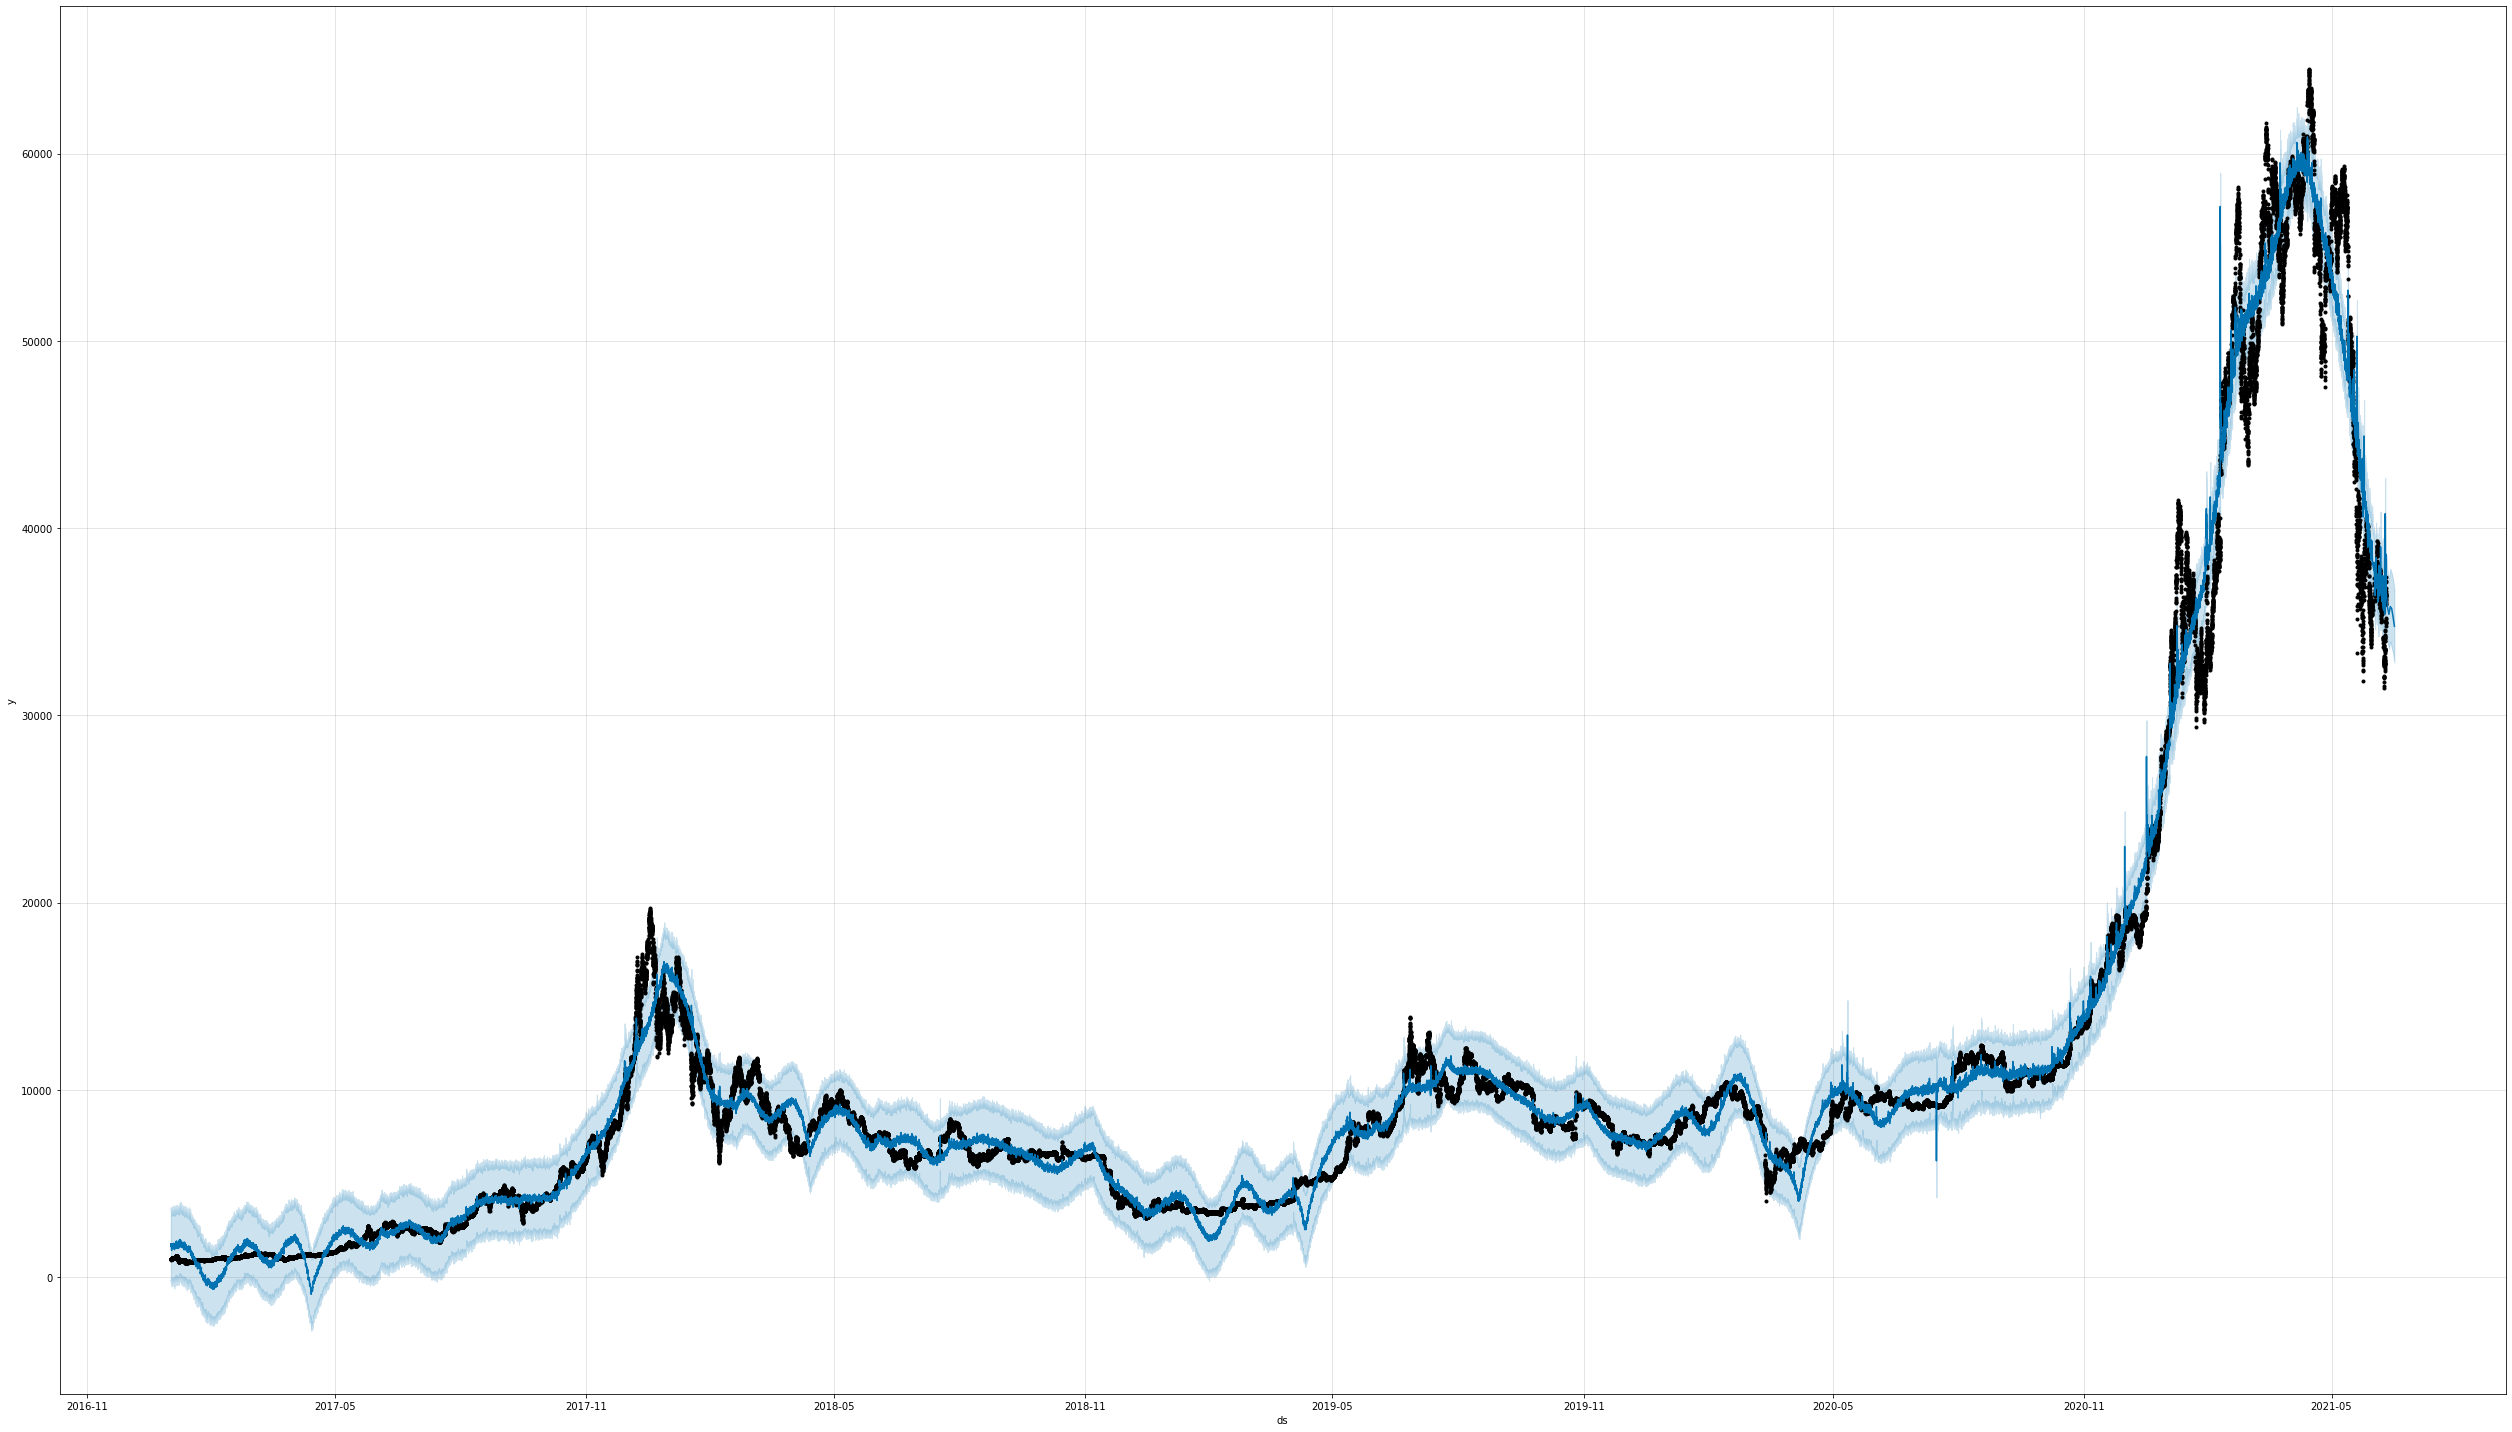

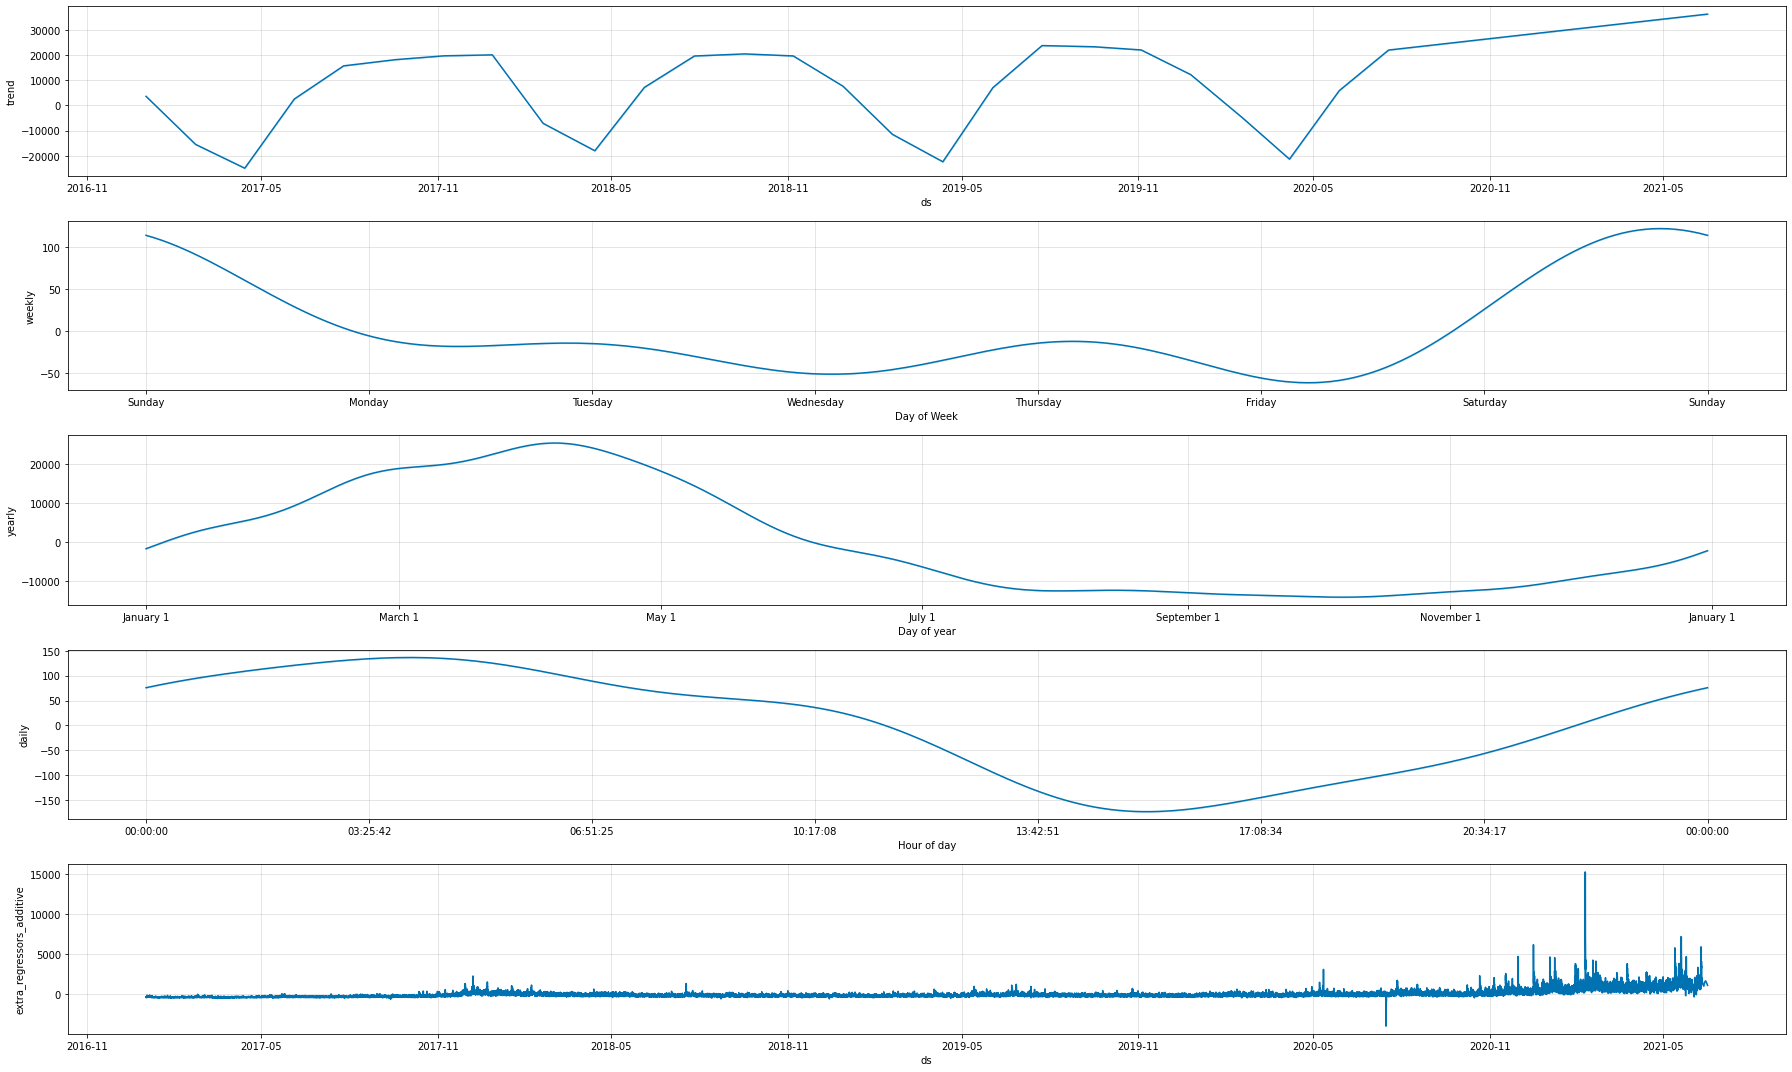

In [175]:
model.plot(forecast, figsize=(35, 20))
model.plot_components(forecast, figsize=(25, 15))